In [ ]:
import sys
sys.path.append("../")  # path contains python_file.py

In [2]:
import iris
import numpy as np
import scipy.stats
from cf_units import num2date

In [3]:
%load_ext autoreload
%autoreload 2

# Helpers:

This reads in the ISIMIP-testing data and gets the dates (last coordinate):

In [11]:
# Given an iris-cube this returns the dates stored in the last time-dimension
def get_dates(x):
    time_dimension = x.coords()[2]
    dates = time_dimension.units.num2date(time_dimension.points)
    return dates

get_dates = np.vectorize(get_dates)

# This reads in the testing-data from ISIMIP stored in testing_data/ISIMIP
def read_in_and_preprocess_isimip_testing_data_with_dates(variable, isimip_data_path = "testing_data/ISIMIP/"):
    
    # Load in data
    obs = iris.load_cube(isimip_data_path+variable+"_obs-hist_coarse_1979-2014.nc")
    cm_hist = iris.load_cube(isimip_data_path+variable+"_sim-hist_coarse_1979-2014.nc")
    cm_future = iris.load_cube(isimip_data_path+variable+"_sim-fut_coarse_2065-2100.nc")

    # Extract dates
    dates = {
        "time_obs_hist": get_dates(obs),
        "time_cm_hist": get_dates(cm_hist),
        "time_cm_future": get_dates(cm_future)
    }
    
    # Convert to np.array (from masked-array)
    obs = np.array(obs.data)
    cm_hist = np.array(cm_hist.data)
    cm_future = np.array(cm_future.data)

    # Move time to first axis (our convention)
    obs = np.moveaxis(obs, -1, 0)
    cm_hist = np.moveaxis(cm_hist, -1, 0)
    cm_future = np.moveaxis(cm_future, -1, 0)
    
    return obs, cm_hist, cm_future, dates

# Run ISIMIP for one variable

In [5]:
from PACKAGE_NAME.debias import ISIMIP
variable = "tas"

In [6]:
obs, cm_hist, cm_future, dates = read_in_and_preprocess_isimip_testing_data_with_dates(variable)

Run with running-window-mode (ISIMIP v2.5):

`debiaser.apply(obs, cm_hist, cm_future, **dates)` is equivalent to : `debiaser.apply(obs, cm_hist, cm_future, time_obs_hist = dates["time_obs_hist"], time_cm_hist = dates["time_cm_hist"], time_cm_future = dates["time_cm_future"])`

In [7]:
debiaser = ISIMIP.from_variable(variable)
debiased_values1 = debiaser.apply(obs, cm_hist, cm_future, **dates)

----- Running debiasing -----


100%|██████████| 4/4 [00:12<00:00,  3.17s/it]


Run via chunking by months:

In [8]:
debiaser = ISIMIP.from_variable(variable)
debiaser.running_window_mode = False
debiased_values2 = debiaser.apply(obs, cm_hist, cm_future, **dates)

----- Running debiasing -----


100%|██████████| 4/4 [00:00<00:00,  5.62it/s]


Run without specifying dates (these are inferred for detrending) -- ISIMIP then runs automatically in running-window mode:

In [9]:
debiaser = ISIMIP.from_variable(variable)
debiased_values3 = debiaser.apply(obs, cm_hist, cm_future)

----- Running debiasing -----


  0%|          | 0/4 [00:00<?, ?it/s]WARNING:root:
                    ISIMIP runs in running window mode without time-information.
                    A standard length of 365 days is assumed for the year and observations are chunked using this.
                    This can lead to slight numerical differences due to leap years
                    
 25%|██▌       | 1/4 [00:03<00:10,  3.38s/it]WARNING:root:
                    ISIMIP runs in running window mode without time-information.
                    A standard length of 365 days is assumed for the year and observations are chunked using this.
                    This can lead to slight numerical differences due to leap years
                    
 50%|█████     | 2/4 [00:06<00:06,  3.28s/it]WARNING:root:
                    ISIMIP runs in running window mode without time-information.
                    A standard length of 365 days is assumed for the year and observations are chunked using this.
                    This can lead

# Compare in one plot

For debiased_values1:

Location: (0, 0)


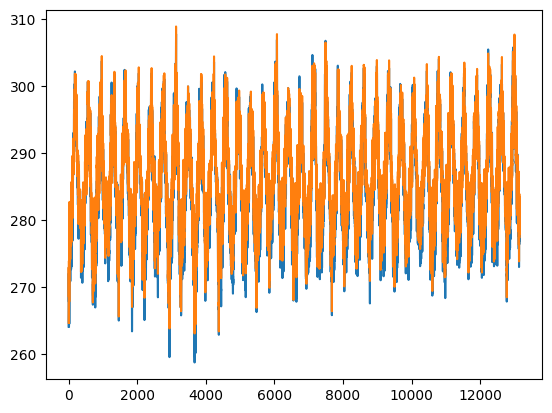

Location: (0, 1)


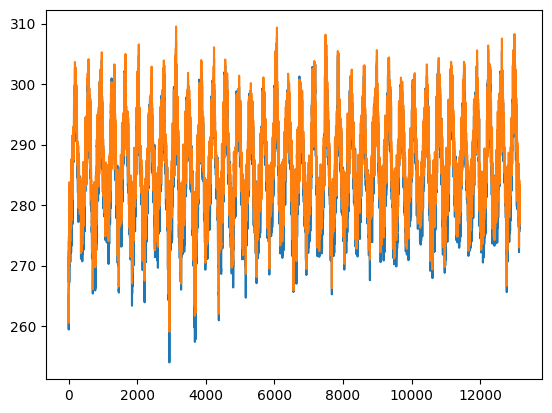

Location: (1, 0)


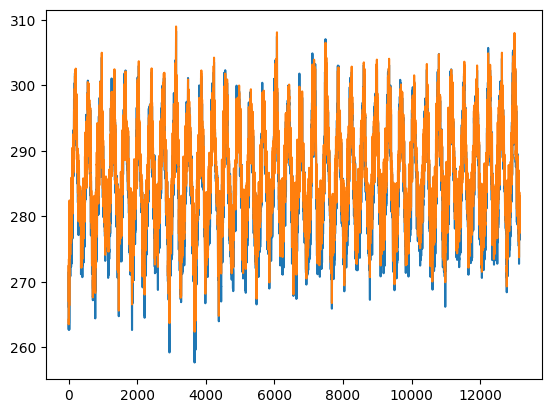

Location: (1, 1)


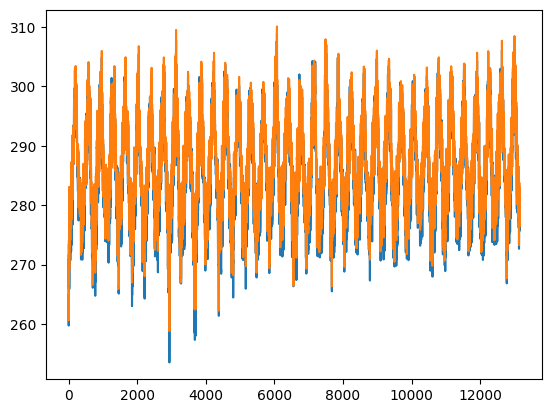

In [12]:
import matplotlib.pyplot as plt

for i in range(2):
    for j in range(2):
        print("Location: (%s, %s)"%(i,j))
        time = list(range(cm_future.shape[0]))
        plt.plot(time, cm_future[:, i, j])
        plt.plot(time, debiased_values1[:, i, j])
        plt.show()